In [1]:
import numpy as np
from datetime import datetime 
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

#distributed library
import torch.distributed as dist
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

/s/jawar/f/nobackup/Saira/miniconda3/envs/venv3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /s/jawar/f/nobackup/Saira/miniconda3/envs/venv3/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
cuda_mem_start = torch.cuda.memory_allocated(DEVICE)

In [3]:
# parameters (TODO: hyperparameter search with self-guided genetic algorithm)
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 64
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 1000
data_path = "/s/jawar/f/nobackup/Saira/IMAGENET/"

# Helper functions

In [4]:
import torch

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, images, labels):
        'Initialization'
        self.labels = labels
        self.images = images

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

  def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        X = self.images[index]
        y = self.labels[index]

        return X, y

# ImageNet Data

In [5]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'train_data_batch_')

    d = unpickle(data_file + str(idx))
    x = d['data']
    y = d['labels']
    mean_image = d['mean']

    x = x/np.float32(255)
    mean_image = mean_image/np.float32(255)

    # Labels are indexed from 1, shift it so that indexes start at 0
    y = [i-1 for i in y if i < 501]
    data_size = x.shape[0]


    x -= mean_image

    img_size2 = img_size * img_size

    x = np.dstack((x[:, :img_size2], x[:, img_size2:2*img_size2], x[:, 2*img_size2:]))
    x = x.reshape((x.shape[0], img_size, img_size, 3)).transpose(0, 3, 1, 2)

    # create mirrored images
    X_train = np.array(x[0:data_size, :, :, :])
    Y_train = np.array(y[0:data_size])
    X_train_flip = X_train[:, :, :, ::-1]
    Y_train_flip = Y_train
#     X_train = np.concatenate((X_train, X_train_flip), axis=0)
#     Y_train = np.concatenate((Y_train, Y_train_flip), axis=0)

    return dict(
        X_train=torch.from_numpy(X_train),
        Y_train=torch.from_numpy(Y_train),
        mean=mean_image)
def load_valdata(data_folder , mean_image, img_size=32):
    data_file = os.path.join(data_folder, 'val_data')

    d = unpickle(data_file)
    x = d['data']
    y = d['labels']

    x = x/np.float32(255)

    # Labels are indexed from 1, shift it so that indexes start at 0
    y = [i-1 for i in y if i < 501]
    data_size = x.shape[0]

    x -= mean_image

    img_size2 = img_size * img_size

    x = np.dstack((x[:, :img_size2], x[:, img_size2:2*img_size2], x[:, 2*img_size2:]))
    x = x.reshape((x.shape[0], img_size, img_size, 3)).transpose(0, 3, 1, 2)

    # create mirrored images
    X_val = np.array(x[0:data_size, :, :, :])
    Y_val = np.array(y[0:data_size])
#     X_val_flip = X_train[:, :, :, ::-1]
#     Y_val_flip = Y_train
#     X_val = np.concatenate((X_val, X_val_flip), axis=0)
#     Y_val = np.concatenate((X_val, Y_train_flip), axis=0)

    return dict(
        X_val=torch.from_numpy(X_val),
        Y_val=torch.from_numpy(Y_val))

In [8]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    

 
    # Train model
    for epoch in range(0, epochs):

        for batch_no in range(1,11):
        
            batch = load_databatch(data_path + "Imagenet32_train/", batch_no)
            val_data = load_valdata(data_path, batch['mean'])

            train_dataset = Dataset(batch['X_train'], batch['Y_train'])
            val_dataset = Dataset(val_data['X_val'], val_data['Y_val'])

            train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
            valid_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

            # training
            model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
            train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

# LeNet 5

In [6]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [7]:
torch.manual_seed(RANDOM_SEED)
N_CLASSES = 500
model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [9]:
cuda_mem_at_model_init = torch.cuda.memory_allocated(DEVICE)

16:47:10 --- Epoch: 0	Train loss: 6.2148	Valid loss: 6.2241	Train accuracy: 0.22	Valid accuracy: 0.21
16:51:44 --- Epoch: 1	Train loss: 6.2146	Valid loss: 6.2187	Train accuracy: 0.25	Valid accuracy: 0.18
16:56:14 --- Epoch: 2	Train loss: 6.2145	Valid loss: 6.2197	Train accuracy: 0.27	Valid accuracy: 0.20
17:00:49 --- Epoch: 3	Train loss: 6.2144	Valid loss: 6.2207	Train accuracy: 0.27	Valid accuracy: 0.23
17:05:22 --- Epoch: 4	Train loss: 6.2144	Valid loss: 6.2197	Train accuracy: 0.27	Valid accuracy: 0.16
17:09:53 --- Epoch: 5	Train loss: 6.2145	Valid loss: 6.2199	Train accuracy: 0.28	Valid accuracy: 0.23
17:14:32 --- Epoch: 6	Train loss: 6.2143	Valid loss: 6.2209	Train accuracy: 0.23	Valid accuracy: 0.16
17:19:09 --- Epoch: 7	Train loss: 6.2142	Valid loss: 6.2226	Train accuracy: 0.26	Valid accuracy: 0.19
17:23:50 --- Epoch: 8	Train loss: 6.2139	Valid loss: 6.2255	Train accuracy: 0.30	Valid accuracy: 0.22
17:28:34 --- Epoch: 9	Train loss: 6.2141	Valid loss: 6.2214	Train accuracy: 0.30	V

/tmp/ipykernel_2318511/671524968.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


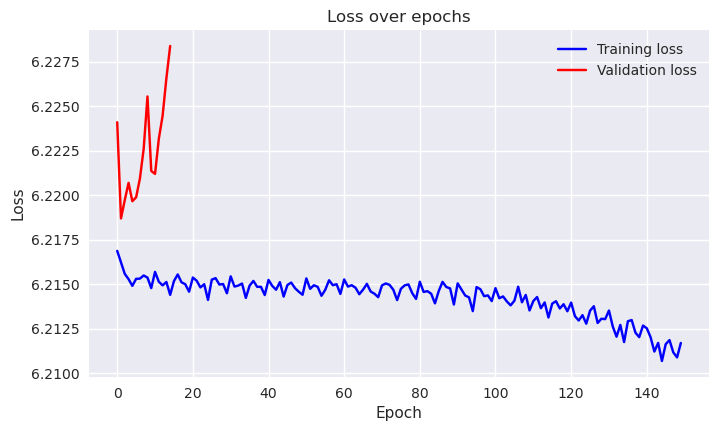

In [10]:
model, optimizer, _ = training_loop(model, criterion, optimizer, N_EPOCHS, DEVICE)

In [16]:
cuda_mem_after_training = torch.cuda.memory_allocated(DEVICE)

In [17]:
cuda_mem_after_training

2347008

In [18]:
def create_image(data, mean):
    img_size = 32
    img_size2 = img_size * img_size
    img = data
    mean_img = np.dstack((mean[:img_size2], mean[img_size2:2*img_size2], mean[2*img_size2:]))
    mean_img = mean_img.reshape(img_size, img_size, 3)
    #print(mean_img.shape)
    img = img.permute(1, 2, 0)
    #print(img.shape)
    return img + mean_img

Inference Memomry-Time Profiling

In [26]:
from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        with torch.no_grad():
            model.eval()
            input_tensor = val_dataset[0][0].unsqueeze(0).to(DEVICE) 
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     model_inference         6.62%     190.000us        98.64%       2.831ms       2.831ms       0.000us         0.00%       2.000us       2.000us          -4 b        -268 b           0 b     -12.00 Kb             1  
                            aten::to         5.30%     152

In [22]:
import math

def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

In [25]:
print("CUDA MEM BEFORE MODEL INIT : " + convert_size(cuda_mem_start))
print("CUDA MEM AFTER MODEL INIT : " + convert_size(cuda_mem_at_model_init))
print("CUDA MEM AFTER MODEL TRAINING : " + convert_size(cuda_mem_after_training))


CUDA MEM BEFORE MODEL INIT : 0B
CUDA MEM AFTER MODEL INIT : 573.0 KB
CUDA MEM AFTER MODEL TRAINING : 2.24 MB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

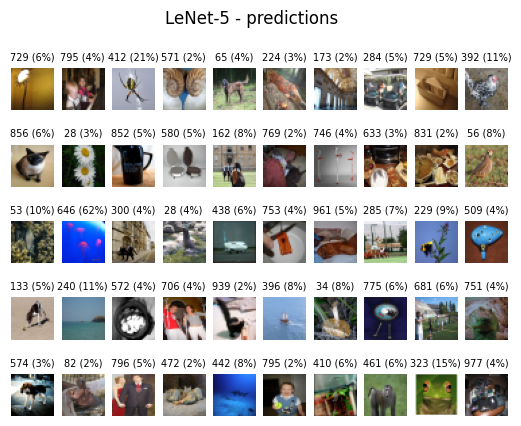

In [57]:
ROW_IMG = 10
N_ROWS = 5


fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    img = create_image(val_dataset.images[index], batch_1['mean']) 
    plt.imshow(img)
    
    with torch.no_grad():
        model.eval()
        input_tensor = val_dataset[index][0].unsqueeze(0).to(DEVICE)  # move input tensor to GPU
        _, probs = model(input_tensor)
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
    
fig.suptitle('LeNet-5 - predictions');
